In [2]:
import pandas as pd
import numpy as np
import nltk
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.corpus import stopwords 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import re
import string
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Data collection script

# // Load variable amount at a time
# var i = 0;
# function loadMore() {         //  create a loop function
#     setTimeout(function() {   //  call a 3s setTimeout when the loop is called
#         document.getElementById('load-more-trigger').click();   //  your code here
#         i++;                    //  increment the counter
#         if (i < 10) {           //  if the counter < 10, call the loop function
#                                 // Loads 25 at a time, divide total number by 25 to get iterations needed
#             console.log(i);
#             loadMore();             //  ..  again which will trigger another 
#         }                       //  ..  setTimeout()
#     }, 5000)
# }
#
# let reviews = document.getElementsByClassName('lister-item-content');
#
# review_data = [];
#
# for (let i = 0; i < reviews.length; i++) {
#     if (reviews[i].getElementsByClassName('rating-other-user-rating').length > 0) {
#         review = {
#             'movie': 'Spider-Man (2002)',
#             'user': reviews[i].getElementsByClassName('display-name-link')[0].innerText,
#             'date': reviews[i].getElementsByClassName('review-date')[0].innerText,
#             // Remove all line breaks and commas from data
#             'title': reviews[i].getElementsByClassName('title')[0].innerText.trim().replace(/(\r\n|\n|\r)/gm, "").replace(/,/g, ''),
#             'review': reviews[i].getElementsByClassName('text show-more__control')[0].innerText.trim().replace(/(\r\n|\n|\r)/gm, "").replace(/,/g, ''),
#             'rating': reviews[i].getElementsByClassName('rating-other-user-rating')[0].innerText.slice(0,-3).trim()
#         }
#         review_data.push(review);
#     }
# }
#
# // Remove duplicates
# let unique_reviews = [...new Map(review_data.map((m) => [m.user, m])).values()]
#
# // Print reviews
# for(let i = 0; i < unique_reviews.length; i++) {
#     console.log(unique_reviews[i].movie + ',' + 
#                 unique_reviews[i].user + ',' + 
#                 unique_reviews[i].date + ',' + 
#                 unique_reviews[i].title + ',' + 
#                 unique_reviews[i].review + ',' +
#                 unique_reviews[i].rating + '\n')
# }

In [33]:
# Combine all reviews into a single dataframe
df = pd.read_csv('365-days_reviews.csv', names=['movie', 'user', 'date', 'title', 'review', 'rating'])
for filename in glob.glob('./reviews/*.csv'):
  df2 = pd.read_csv(filename, names=['movie', 'user', 'date', 'title', 'review', 'rating'])
  df = pd.concat([df,df2])

In [34]:
df

,movie,user,date,title,review,rating
0,365 Days,Neon_Gold,16 June 2020,Insanity,I honestly don't know who thought that this mo...,1.0
1,365 Days,tbyrd-50088,15 June 2020,Straight up porn- no judgement.,I do not even know where to start. Look this i...,1.0
2,365 Days,planktonrules,23 April 2021,Nothing says romance like a kidnapping and sex...,A mobster has a woman he's never met kidnapped...,1.0
3,365 Days,Calicodreamin,21 June 2020,Don't watch for the plot,There is no plot to speak of the dialogue is d...,4.0
4,365 Days,barbaraschum,15 June 2020,I made an account to give this movie a bad review,This was probably the worst movie I've ever se...,1.0
...,...,...,...,...,...,...
2514,Ghostbusters (2016),wzobernig,30 August 2018,Great Movie,Come on. Why does this movie have such a low (...,9.0
2515,Ghostbusters (2016),VeroniqueCL,2 June 2019,Lots of fun for families,I was amazed by the number of poor reviews tha...,8.0
2516,Ghostbusters (2016),jacklynnkitty,13 December 2021,Love it!,Great mix of humor sci fi & Drama. I Loved the...,9.0
2517,Ghostbusters (2016),mrsfredericksmail,23 August 2021,Reviewers Hate Happiness,What is all these reviewers' problem? I think ...,9.0


In [ ]:
l = [pd.read_csv(filename) for filename in glob.glob("./reviews/*.csv")]
df = pd.concat(l, axis=1)
df

In [2]:
# Read data, organize with new uniform headers
headerList = ['movie', 'user', 'date', 'title', 'review', 'rating']
file1 = pd.read_csv('spider-man-1_reviews.csv', names=headerList)
file2 = pd.read_csv('spider-man-2_reviews.csv', names=headerList)
file3 = pd.read_csv('spider-man-3_reviews.csv', names=headerList)

In [3]:
# Create a single large dataframe from all files and drop rows with missing values
df = pd.concat([file1,file2,file3]).dropna()

In [4]:
# Inspect data
df

,movie,user,date,title,review,rating
0,Spider-Man (2002),jaredpahl,5 June 2016,Iconic Electrifying Classy Vibrant and Emotion...,The world of movie superheroes began with Supe...,10.0
1,Spider-Man (2002),ronbell-23984,27 October 2020,Way better than the recent reboots,Really good movie I enjoyed the whole Trilogy ...,9.0
2,Spider-Man (2002),nickmesafilms,19 May 2012,Spider-Man (2002) - With Great Power Comes Gre...,Considered as one of the most successful super...,9.0
3,Spider-Man (2002),safenoe,25 February 2022,Pre MCU,Before the Marvel Cinematic Universe was launc...,10.0
4,Spider-Man (2002),Smells_Like_Cheese,5 May 2002,One of the best movies of the year!!!,Spider-Man is seriously the best movie of the ...,10.0
...,...,...,...,...,...,...
2184,Spider-Man 3,sjchelsea,5 May 2007,All good things must come to an end...,The first two entries into this franchise were...,3.0
2185,Spider-Man 3,bson3605,10 May 2007,Great movie with spectacular action and a good...,I just saw the movie and thought it was great....,10.0
2186,Spider-Man 3,deenimuk,6 May 2007,nice fit as a trilogy,OK by now you have read several reviews. My op...,6.0
2187,Spider-Man 3,Jrbirdman77,12 November 2007,Please sir I want some more.,I think we've said all there is to say about t...,6.0


In [5]:
# Remove unnecessary data (keeping review and rating)
df = df.drop(['movie','user','date','title'], axis=1)

In [6]:
# Remove 'neutral' scores (ratings of 5 and 6)
df = df.drop(df[(df.rating < 7) & (df.rating > 4)].index)

In [ ]:
# Inspect data
df

In [7]:
# Replace negative label with 1 and positive ratings with 0
df['rating'] = np.where(df['rating'] > 5, 0, 1)

In [ ]:
df

In [8]:
# Clean the data, convert to lowercase
df['review'] = df['review'].str.lower()

# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    text=re.sub(r'[^a-zA-z0-9\s]','',text)
    return text

df['review'] = df['review'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

# Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

# Inspect results
df

,review,rating
0,the world of movie superheroes began with supe...,0
1,really good movie i enjoyed the whole trilogy ...,0
2,considered as one of the most successful super...,0
3,before the marvel cinematic universe was launc...,0
4,spiderman is seriously the best movie of the s...,0
...,...,...
2182,for the most part this movie was great plenty ...,0
2183,so after waiting a long time to watch the new ...,0
2184,the first two entries into this franchise were...,1
2185,i just saw the movie and thought it was great ...,0


In [9]:
# Inspect positive and negative counts
df['rating'].value_counts()

0    2715
1     816
Name: rating, dtype: int64

In [10]:
# Remove tags and links
tag = re.compile(r'<[^>]+>')

df['review'] = df['review'].apply(lambda x: tag.sub('', x)) # Remove HTML labels

df['review'] = df['review'].replace(r'http\S+', '', regex=True).replace(r'www.\S+', '', regex=True).replace(r'http\S+', '', regex=True).replace(r'"', '', regex=True)


In [ ]:
df

In [11]:
# Perform tokenization and lemmanization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(review):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in w_tokenizer.tokenize(review)])

df['review'] = df.review.apply(lemmatize_text).copy()

df

,review,rating
0,the world of movie superheroes begin with supe...,0
1,really good movie i enjoy the whole trilogy wi...,0
2,consider as one of the most successful superhe...,0
3,before the marvel cinematic universe be launch...,0
4,spiderman be seriously the best movie of the s...,0
...,...,...
2182,for the most part this movie be great plenty o...,0
2183,so after wait a long time to watch the new spi...,0
2184,the first two entries into this franchise be n...,1
2185,i just saw the movie and think it be great i h...,0


In [12]:
# Split dataset into train, text, and validation sets
x = pd.DataFrame(df, columns = ['review']) 
y = pd.DataFrame(df, columns = ['rating']) 

# Split dataset to train and test set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Split train dataset to train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", Y_train.shape)
print("Shape of x_test:  ", X_test.shape)
print("Shape of y_test:  ", Y_test.shape)
print("Shape of x_val:  ", X_val.shape)
print("Shape of y_val:  ", Y_val.shape)

Shape of x_train:  (2259, 1)
Shape of y_train:  (2259, 1)
Shape of x_test:   (707, 1)
Shape of y_test:   (707, 1)
Shape of x_val:   (565, 1)
Shape of y_val:   (565, 1)


In [13]:
# Vectorize
from sklearn.feature_extraction.text import TfidfVectorizer

train = X_train['review'].tolist()
val = X_val['review'].to_list()
test = X_test['review'].tolist()
STOPWORDS = set(stopwords.words('english'))

# Use 1000 features to improve score without crashing memory
tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = tfidfX_train.toarray()

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = tfidfX_val.toarray()

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = tfidfX_test.toarray()

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: (2259, 1000)
TF-IDF test shape: (707, 1000)
TF-IDF val shape: (565, 1000)


In [14]:
# Convert X datasets to tensors.
tfidfX_train = torch.tensor(tfidfX_train)
tfidfX_val = torch.tensor(tfidfX_val)
tfidfX_test = torch.tensor(tfidfX_test)

In [15]:
# Convert Y labels to tensors with torch.squeeze.
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

In [16]:
device = torch.device("cpu")

In [84]:
# Build model with 2 hidden layers
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1) 
        # self.dropout = nn.Dropout(0.3)
        # self.batch1 = nn.BatchNorm1d(hidden_dim)
        
        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)  

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

In [85]:
# Initialize model
# Dimensions of each layer and num of epochs.
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 512
hidden_dim_2 = 512
output_dim = 1
num_epochs = 50

# Define our first feed forward neural network.
first_model = FeedforwardNeuralNetModel(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
optimizer = optim.Adam(first_model.parameters(),lr=0.1e-3,weight_decay=1e-3)

# Transfer all the computation to GPU (cuda device).
first_model.to(device)
criterion = criterion.to(device)

In [86]:
# This is a function that calculate the accuracy manually
def calculate_accuracy(y_true, y_pred):  
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  acc = correct.sum() / len(correct)
  return acc

batch_size = 512

# Split train dataset to mini batches
X_train_mini_batches = torch.split(tfidfX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Start training
for epoch in range(num_epochs):
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in zip(X_train_mini_batches,Y_train_mini_batches):
    
    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = first_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()
    
    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:
    
    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = first_model.forward(tfidfX_val.float())
    val_prediction = torch.squeeze(val_prediction)
    
    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)

    print("Epoch:",epoch, "\n"
      "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
      "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

Epoch: 0 
Train_loss: 0.6816 Train Accuracy: 0.7761 
Validation_loss:   0.6788 Validation Accuracy:   0.754 

Epoch: 1 
Train_loss: 0.6747 Train Accuracy: 0.7761 
Validation_loss:   0.6723 Validation Accuracy:   0.754 

Epoch: 2 
Train_loss: 0.6675 Train Accuracy: 0.7761 
Validation_loss:   0.6655 Validation Accuracy:   0.754 

Epoch: 3 
Train_loss: 0.6598 Train Accuracy: 0.7761 
Validation_loss:   0.658 Validation Accuracy:   0.754 

Epoch: 4 
Train_loss: 0.6515 Train Accuracy: 0.7761 
Validation_loss:   0.6499 Validation Accuracy:   0.754 

Epoch: 5 
Train_loss: 0.6424 Train Accuracy: 0.7761 
Validation_loss:   0.6411 Validation Accuracy:   0.754 

Epoch: 6 
Train_loss: 0.6325 Train Accuracy: 0.7761 
Validation_loss:   0.6315 Validation Accuracy:   0.754 

Epoch: 7 
Train_loss: 0.6216 Train Accuracy: 0.7761 
Validation_loss:   0.621 Validation Accuracy:   0.754 

Epoch: 8 
Train_loss: 0.6097 Train Accuracy: 0.7761 
Validation_loss:   0.6095 Validation Accuracy:   0.754 

Epoch: 9 
Tr

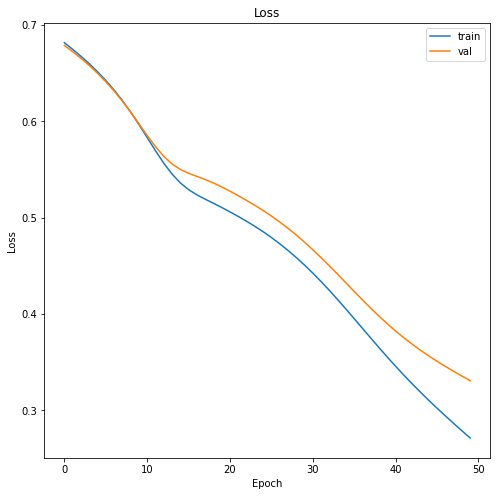

In [87]:
# Plot loss vs epochs
figure(figsize=(8,8)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

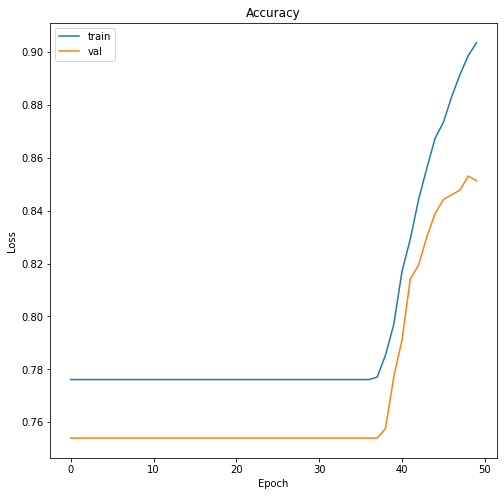

In [88]:
# Plot accuracy vs epochs
figure(figsize=(8,8)) 
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [89]:
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
test_prediction = first_model.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

# Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.8529 



In [90]:
# Show classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       539
         1.0       0.92      0.42      0.57       168

    accuracy                           0.85       707
   macro avg       0.88      0.70      0.74       707
weighted avg       0.86      0.85      0.83       707

